In [2]:
# QPS 采样：在已加载的代理模型 (UNet + Text Encoder) 上做 1000 次参数噪声采样，每次生成 4 张图

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from pathlib import Path
from contextlib import ExitStack

import torch
from diffusers import StableDiffusionPipeline

# ===== 你的现有配置 =====
PROMPT = "a photo of sks person"
TEXT_ENCODER_PTH = "/data/home/yekai/github/DiffAdvPerturbationBench/Algorithms/Anti-DreamBooth/exp_datas_output/aspl_VGGFace2_SD21_random50_r8_savemodels_aglr5e-5/exp_data_ASPL-id0-r8-steps50-1756528573/models/50/text_encoder.pth"
UNET_PTH        = "/data/home/yekai/github/DiffAdvPerturbationBench/Algorithms/Anti-DreamBooth/exp_datas_output/aspl_VGGFace2_SD21_random50_r8_savemodels_aglr5e-5/exp_data_ASPL-id0-r8-steps50-1756528573/models/50/unet.pth"
MODEL_DIR       = "/data/home/yekai/github/DiffAdvPerturbationBench/SD/stable-diffusion-2-1-base"
# ===== 采样与推理超参 =====
N_SAMPLES   = 1000     # 采样次数（每次 4 张）
IMAGES_PER  = 4        # 每次生成的张数
STEPS       = 100      # 推理步数
GUIDANCE    = 7.5      # CFG
WIDTH, HEIGHT = 512, 512
start_id = 0
# ===== 噪声控制：二选一 =====
NOISE_MODE   = "fixed"   # "rms" 或 "fixed"
ALPHA_UNET   = 0.03    # NOISE_MODE="rms" 时生效：sigma_layer = ALPHA * RMS(W)
ALPHA_TEXT   = 0.01

# SIGMA_UNET   = 1e-3*1    # NOISE_MODE="fixed" 时生效：sigma_layer = SIGMA
# SIGMA_TEXT   = 5e-4*1

SIGMA_UNET   = 0.001    # NOISE_MODE="fixed" 时生效：sigma_layer = SIGMA
SIGMA_TEXT   = 0.001

OUT_DIR         = f"./samples/outputs_sd21_base_replaced_qps1000_unet{SIGMA_UNET}_text{SIGMA_TEXT}"
# ===== 是否排除某些参数（更稳）=====
EXCLUDE_BIAS_NORM = True       # 跳过 bias / norm(ln/gn/bn) 参数
EXCLUDE_EMBEDDINGS = True      # 跳过嵌入层(embedding/positional)等

# ===== 随机性（可复现）=====
BASE_SEED = 20250829

# ---------- 工具函数 ----------
def _strip_module_prefix(state_dict):
    if any(k.startswith("module.") for k in state_dict.keys()):
        return {k.replace("module.", "", 1): v for k, v in state_dict.items()}
    return state_dict

@torch.no_grad()
def replace_unet_and_text_encoder(pipe, unet_pth=None, text_encoder_pth=None, device="cuda"):
    orig_unet_dtype = next(pipe.unet.parameters()).dtype
    orig_te_dtype   = next(pipe.text_encoder.parameters()).dtype

    # UNet
    if unet_pth:
        obj = torch.load(unet_pth, map_location="cpu")
        sd = _strip_module_prefix(obj["state_dict"] if isinstance(obj, dict) and "state_dict" in obj else obj)
        new_unet = pipe.unet.__class__.from_config(pipe.unet.config)
        missing, unexpected = new_unet.load_state_dict(sd, strict=False)
        print(f"[UNet] missing: {len(missing)}, unexpected: {len(unexpected)}")
        pipe.unet = new_unet.to(device=device, dtype=orig_unet_dtype)

    # Text Encoder
    if text_encoder_pth:
        obj = torch.load(text_encoder_pth, map_location="cpu")
        sd = _strip_module_prefix(obj["state_dict"] if isinstance(obj, dict) and "state_dict" in obj else obj)
        new_te = pipe.text_encoder.__class__(pipe.text_encoder.config)
        missing, unexpected = new_te.load_state_dict(sd, strict=False)
        print(f"[TextEncoder] missing: {len(missing)}, unexpected: {len(unexpected)}")
        pipe.text_encoder = new_te.to(device=device, dtype=orig_te_dtype)

    return pipe

def tensor_rms(t: torch.Tensor):
    if t.numel() == 0:
        return torch.tensor(0.0, device=t.device, dtype=t.dtype)
    return (t.float().pow(2).mean().sqrt().clamp_min(1e-12)).to(t.dtype)

def _should_skip(name: str):
    lname = name.lower()
    if EXCLUDE_BIAS_NORM and ("bias" in lname or "norm" in lname or "ln" in lname or "layernorm" in lname or "groupnorm" in lname or "batchnorm" in lname):
        return True
    if EXCLUDE_EMBEDDINGS and ("embed" in lname or "pos" in lname and "embedding" in lname):
        return True
    return False

@torch.no_grad()
def add_noise_inplace(module: torch.nn.Module, *, mode: str, alpha: float, sigma_fixed: float, g: torch.Generator):
    """
    对 module 的每个参数添加各向同性高斯噪声：
      NOISE_MODE="rms":    sigma_layer = alpha * RMS(W)
      NOISE_MODE="fixed":  sigma_layer = sigma_fixed
    返回 restore() 闭包用于恢复原值。
    """
    backups = []
    for name, p in module.named_parameters(recurse=True):
        if not p.requires_grad:
            continue
        if _should_skip(name):
            continue
        if mode == "rms":
            sigma = (alpha * tensor_rms(p.data)).to(p.dtype)
        elif mode == "fixed":
            sigma = torch.as_tensor(sigma_fixed, device=p.device, dtype=p.dtype)
        else:
            raise ValueError(f"Unknown NOISE_MODE: {mode}")
        if float(sigma) == 0.0:
            continue
        noise = torch.randn(p.shape, device=p.device, dtype=p.dtype, generator=g) * sigma
        backups.append((p, p.data.detach().clone()))
        p.add_(noise)

    def restore():
        for p, buf in backups:
            p.data.copy_(buf)
        backups.clear()

    return restore

def ensure_dir(path: str):
    Path(path).mkdir(parents=True, exist_ok=True)

# ---------- 加载 Pipeline 与代理参数 ----------
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype  = torch.float16 if device == "cuda" else torch.float32

pipe = StableDiffusionPipeline.from_pretrained(
    MODEL_DIR,
    torch_dtype=dtype,
    safety_checker=None,
    local_files_only=True,
).to(device)

pipe = replace_unet_and_text_encoder(
    pipe,
    unet_pth=UNET_PTH,
    text_encoder_pth=TEXT_ENCODER_PTH,
    device=device,
)

# 省显存
if device == "cuda":
    try:
        pipe.enable_xformers_memory_efficient_attention()
    except Exception:
        pass
    pipe.enable_attention_slicing()
    pipe.enable_vae_slicing()

# ---------- 进行 N 次采样 ----------
ensure_dir(OUT_DIR)

# for i in range(start_id,N_SAMPLES):
#     sample_dir = Path(OUT_DIR) / f"sample_{i:04d}"
#     ensure_dir(sample_dir)

#     # 为本次采样构造子种子（可复现），并分别给 UNet/TextEncoder 噪声与图像生成用
#     g_unet = torch.Generator(device=device).manual_seed(BASE_SEED * 100000 + i * 2 + 0)
#     g_text = torch.Generator(device=device).manual_seed(BASE_SEED * 100000 + i * 2 + 1)

#     # 加噪 & 生成（try/finally 确保恢复）
#     restore_unet = add_noise_inplace(
#         pipe.unet, mode=NOISE_MODE, alpha=ALPHA_UNET, sigma_fixed=SIGMA_UNET, g=g_unet
#     )
#     restore_text = add_noise_inplace(
#         pipe.text_encoder, mode=NOISE_MODE, alpha=ALPHA_TEXT, sigma_fixed=SIGMA_TEXT, g=g_text
#     )

#     try:
#         for j in range(IMAGES_PER):
#             g_img = torch.Generator(device=device).manual_seed(BASE_SEED * 10_000 + i * IMAGES_PER + j)
#             image = pipe(
#                 PROMPT,
#                 num_inference_steps=STEPS,
#                 guidance_scale=GUIDANCE,
#                 width=WIDTH,
#                 height=HEIGHT,
#                 generator=g_img,
#             ).images[0]
#             image.save(sample_dir / f"{j:03d}.png")
#     finally:
#         # 无论成功与否都恢复参数，避免噪声累积
#         restore_text()
#         restore_unet()

print(f"All done. Root output dir: {OUT_DIR}")

/data/home/yekai/conda_envs/Metacloakp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-12 20:29:18.544187: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-12 20:29:18.590619: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-12 20:29:19.404798: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: C

[UNet] missing: 0, unexpected: 0


/tmp/ipykernel_2714313/621046571.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  obj = torch.load(text_encoder_pth, map_location="cpu")


[TextEncoder] missing: 0, unexpected: 0
All done. Root output dir: ./samples/outputs_sd21_base_replaced_qps1000_unet0.001_text0.001


#### 计算样本指标

#### 无噪声

[Ref] 4 images encoded. Embedding dim=512
[Gen] Found 1000 sample groups (expect 1000).
[CSV] Saved: outputs_sd21_base_replaced_qps1000/clip_distance_per_group.csv


/tmp/ipykernel_4057942/2687087775.py:152: UserWarning: Glyph 24863 (\N{CJK UNIFIED IDEOGRAPH-611F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4057942/2687087775.py:152: UserWarning: Glyph 30693 (\N{CJK UNIFIED IDEOGRAPH-77E5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4057942/2687087775.py:152: UserWarning: Glyph 36317 (\N{CJK UNIFIED IDEOGRAPH-8DDD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4057942/2687087775.py:152: UserWarning: Glyph 31163 (\N{CJK UNIFIED IDEOGRAPH-79BB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4057942/2687087775.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4057942/2687087775.py:152: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4057942/2687087775.py:152: UserWarning: Glyph 65288 (\N

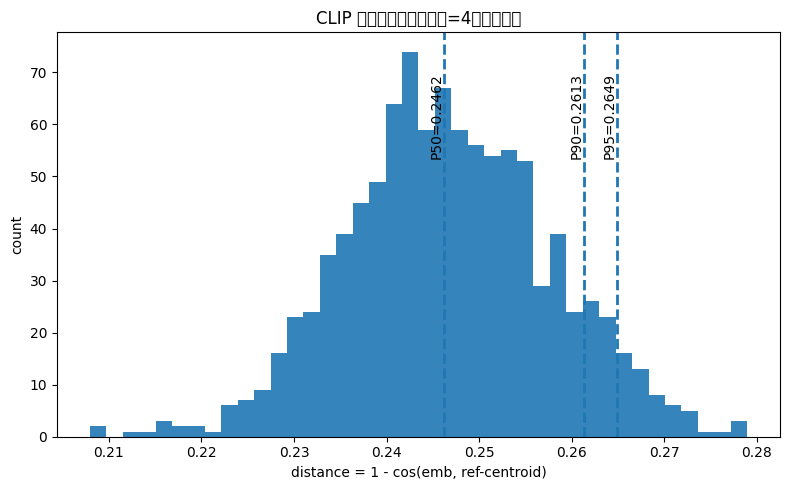

/tmp/ipykernel_4057942/2687087775.py:170: UserWarning: Glyph 24863 (\N{CJK UNIFIED IDEOGRAPH-611F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4057942/2687087775.py:170: UserWarning: Glyph 30693 (\N{CJK UNIFIED IDEOGRAPH-77E5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4057942/2687087775.py:170: UserWarning: Glyph 36317 (\N{CJK UNIFIED IDEOGRAPH-8DDD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4057942/2687087775.py:170: UserWarning: Glyph 31163 (\N{CJK UNIFIED IDEOGRAPH-79BB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4057942/2687087775.py:170: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4057942/2687087775.py:170: UserWarning: Glyph 27599 (\N{CJK UNIFIED IDEOGRAPH-6BCF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4057942/2687087775.py:170: UserWarning: Glyph 32452 (\N

[Plot] Saved histogram: outputs_sd21_base_replaced_qps1000/clip_distance_hist.png


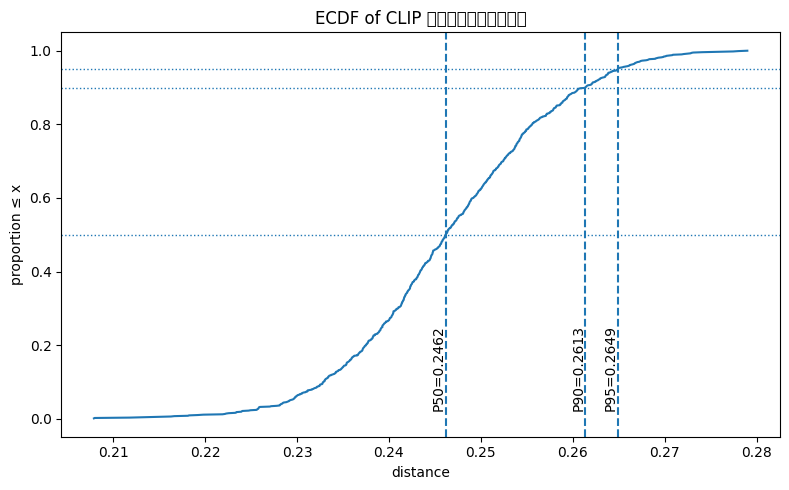

[Plot] Saved ECDF: outputs_sd21_base_replaced_qps1000/clip_distance_ecdf.png
样本组数: 1000, 有效统计组: 1000
分位点： {'P50': 0.24618376046419144, 'P90': 0.2613472998142242, 'P95': 0.2649179667234421}
均值: 0.246596 | 中位数: 0.246184 | 最小: 0.207925 | 最大: 0.278971


In [2]:
# === 计算 1000 组生成样本相对参考图的 CLIP 感知距离，并可视化分布 ===
import os, math, csv, glob
from pathlib import Path

import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# --------- 路径与设置（按需修改）---------
GENERATED_ROOT = "./outputs_sd21_base_replaced_qps1000"  # 你前面采样输出的根目录
REF_DIR = "/data/home/yekai/github/DiffAdvPerturbationBench/Algorithms/Anti-DreamBooth/exp_datas_output/aspl_VGGFace2_SD21_random10_r8_savemodels_aglr5e-5/exp_data_ASPL-id0-r8-steps50-1756528573/image_clean_ref"

OUT_CSV = Path(GENERATED_ROOT) / "clip_distance_per_group.csv"
SAVE_HIST = Path(GENERATED_ROOT) / "clip_distance_hist.png"
SAVE_ECDF = Path(GENERATED_ROOT) / "clip_distance_ecdf.png"

# 选择 CLIP 模型（open_clip 优先；否则回退到 clip）
CLIP_BACKEND = None            # 自动检测：'open_clip' 或 'clip'
OPENCLIP_MODEL = "ViT-B-32"
OPENCLIP_CHECKPOINT = "laion2b_s34b_b79k"
CLIP_MODEL_FALLBACK = "ViT-B/32"  # for openai/clip

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH = 32  # 批大小，按显存调整
TORCH_DTYPE = torch.float32    # CLIP 通常用 fp32 做特征

# --------- 加载 CLIP（open_clip 优先）---------
def load_clip(device=DEVICE):
    global CLIP_BACKEND
    try:
        import open_clip
        model, _, preprocess = open_clip.create_model_and_transforms(
            OPENCLIP_MODEL, pretrained=OPENCLIP_CHECKPOINT, device=device
        )
        model.eval().to(device=device)
        CLIP_BACKEND = "open_clip"
        return model, preprocess
    except Exception as e1:
        try:
            import clip  # OpenAI CLIP
            model, preprocess = clip.load(CLIP_MODEL_FALLBACK, device=device, jit=False)
            model.eval().to(device=device)
            CLIP_BACKEND = "clip"
            return model, preprocess
        except Exception as e2:
            raise RuntimeError(
                f"无法加载 CLIP。请安装 open-clip 或 clip。\nopen_clip 错误: {e1}\nclip 错误: {e2}"
            )

@torch.no_grad()
def encode_images(model, preprocess, img_paths, device=DEVICE, batch=BATCH):
    """返回 (N, D)的 L2 归一化图像向量"""
    xs = []
    n = len(img_paths)
    for i in range(0, n, batch):
        chunk = img_paths[i:i+batch]
        imgs = [preprocess(Image.open(p).convert("RGB")) for p in chunk]
        t = torch.stack(imgs, dim=0).to(device=device, dtype=TORCH_DTYPE)
        if CLIP_BACKEND == "open_clip":
            feats = model.encode_image(t)
        else:
            # openai/clip
            feats = model.encode_image(t)
        feats = feats.float()
        feats = feats / (feats.norm(dim=-1, keepdim=True) + 1e-12)
        xs.append(feats.cpu())
    return torch.cat(xs, dim=0) if xs else torch.empty(0)

def list_sample_groups(root):
    """返回排序后的 sample 目录列表 e.g. sample_0000, sample_0001, ..."""
    dirs = sorted([p for p in Path(root).glob("sample_*") if p.is_dir()])
    return dirs

def list_images_in_dir(d):
    """列出目录下的png/jpg（排序）"""
    paths = []
    for ext in ("*.png", "*.jpg", "*.jpeg", "*.webp"):
        paths += glob.glob(str(Path(d) / ext))
    return sorted(paths)

# --------- 1) 准备 CLIP 与参考嵌入 ----------
model, preprocess = load_clip(DEVICE)
ref_imgs = list_images_in_dir(REF_DIR)
assert len(ref_imgs) >= 1, f"参考目录 {REF_DIR} 中未找到图片！"

with torch.no_grad():
    ref_embs = encode_images(model, preprocess, ref_imgs, device=DEVICE, batch=BATCH)  # (R, D)
    ref_centroid = ref_embs.mean(dim=0, keepdim=True)
    ref_centroid = ref_centroid / (ref_centroid.norm(dim=-1, keepdim=True) + 1e-12)   # 单位向量 (1, D)
print(f"[Ref] {len(ref_imgs)} images encoded. Embedding dim={ref_centroid.shape[-1]}")

# --------- 2) 遍历 1000 组样本，计算与参考质心的距离 ----------
groups = list_sample_groups(GENERATED_ROOT)
assert len(groups) > 0, f"未找到样本目录 sample_xxxx 于 {GENERATED_ROOT}"
print(f"[Gen] Found {len(groups)} sample groups (expect 1000).")

results = []  # 每组 1 行
all_group_scores = []  # 用于可视化，取每组的平均距离

for gdir in groups:
    gimgs = list_images_in_dir(gdir)
    if len(gimgs) == 0:
        # 允许空组但记录为 nan
        results.append({
            "group": gdir.name, "n_imgs": 0, "mean_dist": math.nan,
            "median_dist": math.nan, "min_dist": math.nan, "max_dist": math.nan
        })
        continue

    with torch.no_grad():
        gen_embs = encode_images(model, preprocess, gimgs, device=DEVICE, batch=BATCH)  # (K, D)
        # 余弦相似（与参考质心），然后转成“感知距离”= 1 - cos
        cos = torch.matmul(gen_embs, ref_centroid.T).squeeze(-1)  # (K,)
        dists = (1.0 - cos).cpu().numpy()  # [0, 2] 区间，越小越相似

    mean_d = float(np.mean(dists))
    med_d  = float(np.median(dists))
    min_d  = float(np.min(dists))
    max_d  = float(np.max(dists))

    results.append({
        "group": gdir.name, "n_imgs": len(gimgs),
        "mean_dist": mean_d, "median_dist": med_d,
        "min_dist": min_d, "max_dist": max_d
    })
    all_group_scores.append(mean_d)

# --------- 3) 保存 CSV ----------
OUT_CSV.parent.mkdir(parents=True, exist_ok=True)
with open(OUT_CSV, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["group","n_imgs","mean_dist","median_dist","min_dist","max_dist"])
    writer.writeheader()
    writer.writerows(results)
print(f"[CSV] Saved: {OUT_CSV}")

# --------- 4) 可视化分布（直方图 + 分位线）---------
vals = np.array([v for v in all_group_scores if not np.isnan(v)])
assert vals.size > 0, "没有有效的组分数用于可视化。"

q_list = [0.5, 0.9, 0.95]
qs = np.quantile(vals, q_list)

plt.figure(figsize=(8,5))
plt.hist(vals, bins=40, alpha=0.9)
for qv, qname in zip(qs, ["P50","P90","P95"]):
    plt.axvline(qv, linestyle="--", linewidth=2)
    plt.text(qv, plt.ylim()[1]*0.9, f"{qname}={qv:.4f}", rotation=90, va="top", ha="right")
plt.title("CLIP 感知距离分布（每组=4张的均值）")
plt.xlabel("distance = 1 - cos(emb, ref-centroid)")
plt.ylabel("count")
plt.tight_layout()
plt.savefig(SAVE_HIST, dpi=150)
plt.show()
print(f"[Plot] Saved histogram: {SAVE_HIST}")

# --------- 5) ECDF（更直观看分位点）---------
sorted_vals = np.sort(vals)
ecdf = np.arange(1, len(sorted_vals)+1) / len(sorted_vals)

plt.figure(figsize=(8,5))
plt.plot(sorted_vals, ecdf)
for qv, qname in zip(qs, ["P50","P90","P95"]):
    plt.axvline(qv, linestyle="--", linewidth=1.5)
    plt.axhline(q_list[["P50","P90","P95"].index(qname)], linestyle=":", linewidth=1.0)
    plt.text(qv, 0.02, f"{qname}={qv:.4f}", rotation=90, va="bottom", ha="right")
plt.title("ECDF of CLIP 感知距离（每组均值）")
plt.xlabel("distance")
plt.ylabel("proportion ≤ x")
plt.tight_layout()
plt.savefig(SAVE_ECDF, dpi=150)
plt.show()
print(f"[Plot] Saved ECDF: {SAVE_ECDF}")

# --------- 6) 小结输出 ----------
print(f"样本组数: {len(groups)}, 有效统计组: {vals.size}")
print("分位点：", {f"P{int(p*100)}": float(q) for p, q in zip(q_list, qs)})
print(f"均值: {vals.mean():.6f} | 中位数: {np.median(vals):.6f} | 最小: {vals.min():.6f} | 最大: {vals.max():.6f}")

#### 有噪声

[Ref] 4 images encoded. Embedding dim=512
[Gen] Found 1000 sample groups (expect 1000).


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

[CSV] Saved: samples/outputs_sd21_base_replaced_qps1000_unet0.001_text0.001/clip_distance_per_group.csv


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

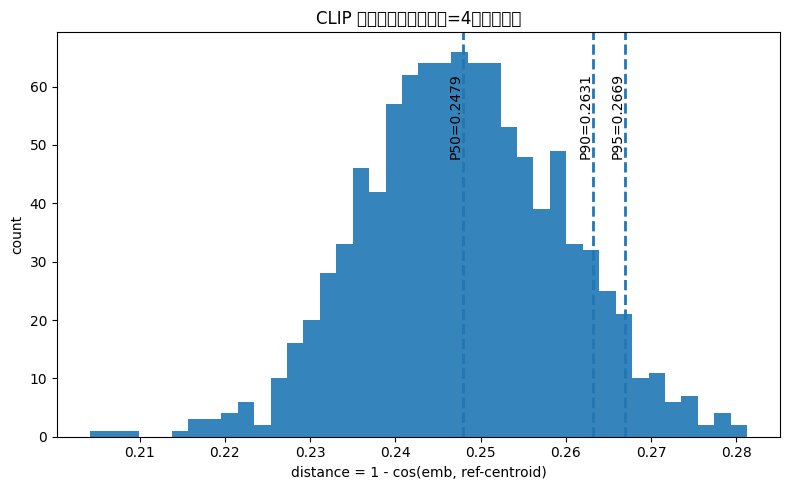

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

[Plot] Saved histogram: samples/outputs_sd21_base_replaced_qps1000_unet0.001_text0.001/clip_distance_hist.png


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

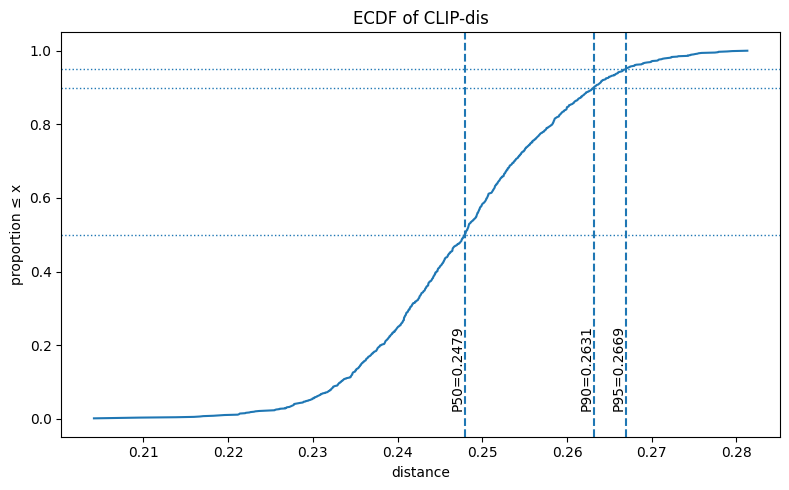

[Plot] Saved ECDF: samples/outputs_sd21_base_replaced_qps1000_unet0.001_text0.001/clip_distance_ecdf.png
样本组数: 1000, 有效统计组: 1000
分位点： {'P50': 0.24792272597551346, 'P90': 0.26314610838890073, 'P95': 0.2669152095913887}
均值: 0.247879 | 中位数: 0.247923 | 最小: 0.204159 | 最大: 0.281280


In [ ]:
# === 计算 1000 组生成样本相对参考图的 CLIP 感知距离，并可视化分布 ===
import os, math, csv, glob
from pathlib import Path

import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] # 设置字体为黑体，解决Matplotlib中文乱码问题

plt.rcParams['axes.unicode_minus']=False # 解决Matplotlib坐标轴负号'-'显示为方块的问题
# --------- 路径与设置（按需修改）---------
GENERATED_ROOT = OUT_DIR
# GENERATED_ROOT = "./outputs_sd21_base_replaced_qps1000_unet1e-3_text5e-4"  # 你前面采样输出的根目录
REF_DIR = "/data/home/yekai/github/DiffAdvPerturbationBench/Algorithms/Anti-DreamBooth/exp_datas_output/aspl_VGGFace2_SD21_random50_r8_savemodels_aglr5e-5/exp_data_ASPL-id0-r8-steps50-1756528573/image_clean_ref"

OUT_CSV = Path(GENERATED_ROOT) / "clip_distance_per_group.csv"
SAVE_HIST = Path(GENERATED_ROOT) / "clip_distance_hist.png"
SAVE_ECDF = Path(GENERATED_ROOT) / "clip_distance_ecdf.png"

# 选择 CLIP 模型（open_clip 优先；否则回退到 clip）
CLIP_BACKEND = None            # 自动检测：'open_clip' 或 'clip'
OPENCLIP_MODEL = "ViT-B-32"
OPENCLIP_CHECKPOINT = "laion2b_s34b_b79k"
CLIP_MODEL_FALLBACK = "ViT-B/32"  # for openai/clip

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH = 32  # 批大小，按显存调整
TORCH_DTYPE = torch.float32    # CLIP 通常用 fp32 做特征

# --------- 加载 CLIP（open_clip 优先）---------
def load_clip(device=DEVICE):
    global CLIP_BACKEND
    try:
        import open_clip
        model, _, preprocess = open_clip.create_model_and_transforms(
            OPENCLIP_MODEL, pretrained=OPENCLIP_CHECKPOINT, device=device
        )
        model.eval().to(device=device)
        CLIP_BACKEND = "open_clip"
        return model, preprocess
    except Exception as e1:
        try:
            import clip  # OpenAI CLIP
            model, preprocess = clip.load(CLIP_MODEL_FALLBACK, device=device, jit=False)
            model.eval().to(device=device)
            CLIP_BACKEND = "clip"
            return model, preprocess
        except Exception as e2:
            raise RuntimeError(
                f"无法加载 CLIP。请安装 open-clip 或 clip。\nopen_clip 错误: {e1}\nclip 错误: {e2}"
            )

@torch.no_grad()
def encode_images(model, preprocess, img_paths, device=DEVICE, batch=BATCH):
    """返回 (N, D)的 L2 归一化图像向量"""
    xs = []
    n = len(img_paths)
    for i in range(0, n, batch):
        chunk = img_paths[i:i+batch]
        imgs = [preprocess(Image.open(p).convert("RGB")) for p in chunk]
        t = torch.stack(imgs, dim=0).to(device=device, dtype=TORCH_DTYPE)
        if CLIP_BACKEND == "open_clip":
            feats = model.encode_image(t)
        else:
            # openai/clip
            feats = model.encode_image(t)
        feats = feats.float()
        feats = feats / (feats.norm(dim=-1, keepdim=True) + 1e-12)
        xs.append(feats.cpu())
    return torch.cat(xs, dim=0) if xs else torch.empty(0)

def list_sample_groups(root):
    """返回排序后的 sample 目录列表 e.g. sample_0000, sample_0001, ..."""
    dirs = sorted([p for p in Path(root).glob("sample_*") if p.is_dir()])
    return dirs

def list_images_in_dir(d):
    """列出目录下的png/jpg（排序）"""
    paths = []
    for ext in ("*.png", "*.jpg", "*.jpeg", "*.webp"):
        paths += glob.glob(str(Path(d) / ext))
    return sorted(paths)

# --------- 1) 准备 CLIP 与参考嵌入 ----------
model, preprocess = load_clip(DEVICE)
ref_imgs = list_images_in_dir(REF_DIR)
assert len(ref_imgs) >= 1, f"参考目录 {REF_DIR} 中未找到图片！"

with torch.no_grad():
    ref_embs = encode_images(model, preprocess, ref_imgs, device=DEVICE, batch=BATCH)  # (R, D)
    ref_centroid = ref_embs.mean(dim=0, keepdim=True)
    ref_centroid = ref_centroid / (ref_centroid.norm(dim=-1, keepdim=True) + 1e-12)   # 单位向量 (1, D)
print(f"[Ref] {len(ref_imgs)} images encoded. Embedding dim={ref_centroid.shape[-1]}")

# --------- 2) 遍历 1000 组样本，计算与参考质心的距离 ----------
groups = list_sample_groups(GENERATED_ROOT)
assert len(groups) > 0, f"未找到样本目录 sample_xxxx 于 {GENERATED_ROOT}"
print(f"[Gen] Found {len(groups)} sample groups (expect 1000).")

results = []  # 每组 1 行
all_group_scores = []  # 用于可视化，取每组的平均距离

for gdir in groups:
    gimgs = list_images_in_dir(gdir)
    if len(gimgs) == 0:
        # 允许空组但记录为 nan
        results.append({
            "group": gdir.name, "n_imgs": 0, "mean_dist": math.nan,
            "median_dist": math.nan, "min_dist": math.nan, "max_dist": math.nan
        })
        continue

    with torch.no_grad():
        gen_embs = encode_images(model, preprocess, gimgs, device=DEVICE, batch=BATCH)  # (K, D)
        # 余弦相似（与参考质心），然后转成“感知距离”= 1 - cos
        cos = torch.matmul(gen_embs, ref_centroid.T).squeeze(-1)  # (K,)
        dists = (1.0 - cos).cpu().numpy()  # [0, 2] 区间，越小越相似

    mean_d = float(np.mean(dists))
    med_d  = float(np.median(dists))
    min_d  = float(np.min(dists))
    max_d  = float(np.max(dists))

    results.append({
        "group": gdir.name, "n_imgs": len(gimgs),
        "mean_dist": mean_d, "median_dist": med_d,
        "min_dist": min_d, "max_dist": max_d
    })
    all_group_scores.append(mean_d)

# --------- 3) 保存 CSV ----------
OUT_CSV.parent.mkdir(parents=True, exist_ok=True)
with open(OUT_CSV, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["group","n_imgs","mean_dist","median_dist","min_dist","max_dist"])
    writer.writeheader()
    writer.writerows(results)
print(f"[CSV] Saved: {OUT_CSV}")

# --------- 4) 可视化分布（直方图 + 分位线）---------
vals = np.array([v for v in all_group_scores if not np.isnan(v)])
assert vals.size > 0, "没有有效的组分数用于可视化。"

q_list = [0.5, 0.9, 0.95]
qs = np.quantile(vals, q_list)

plt.figure(figsize=(8,5))
plt.hist(vals, bins=40, alpha=0.9)
for qv, qname in zip(qs, ["P50","P90","P95"]):
    plt.axvline(qv, linestyle="--", linewidth=2)
    plt.text(qv, plt.ylim()[1]*0.9, f"{qname}={qv:.4f}", rotation=90, va="top", ha="right")
plt.title("CLIP 感知距离分布（每组=4张的均值）")
plt.xlabel("distance = 1 - cos(emb, ref-centroid)")
plt.ylabel("count")
plt.tight_layout()
plt.savefig(SAVE_HIST, dpi=150)
plt.show()
print(f"[Plot] Saved histogram: {SAVE_HIST}")

# --------- 5) ECDF（更直观看分位点）---------
sorted_vals = np.sort(vals)
ecdf = np.arange(1, len(sorted_vals)+1) / len(sorted_vals)

plt.figure(figsize=(8,5))
plt.plot(sorted_vals, ecdf)
for qv, qname in zip(qs, ["P50","P90","P95"]):
    plt.axvline(qv, linestyle="--", linewidth=1.5)
    plt.axhline(q_list[["P50","P90","P95"].index(qname)], linestyle=":", linewidth=1.0)
    plt.text(qv, 0.02, f"{qname}={qv:.4f}", rotation=90, va="bottom", ha="right")
plt.title("ECDF of CLIP-dis")
plt.xlabel("distance")
plt.ylabel("proportion ≤ x")
plt.tight_layout()
plt.savefig(SAVE_ECDF, dpi=150)
plt.show()
print(f"[Plot] Saved ECDF: {SAVE_ECDF}")

# --------- 6) 小结输出 ----------
print(f"样本组数: {len(groups)}, 有效统计组: {vals.size}")
print("分位点：", {f"P{int(p*100)}": float(q) for p, q in zip(q_list, qs)})
print(f"均值: {vals.mean():.6f} | 中位数: {np.median(vals):.6f} | 最小: {vals.min():.6f} | 最大: {vals.max():.6f}")

#### 相似度

[Ref] 4 images encoded. Embedding dim=512
[Gen] Found 1000 sample groups (expect 1000).


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

[CSV] Saved: samples/outputs_sd21_base_replaced_qps1000_unet0.001_text0.001/clip_similarity_per_group.csv


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

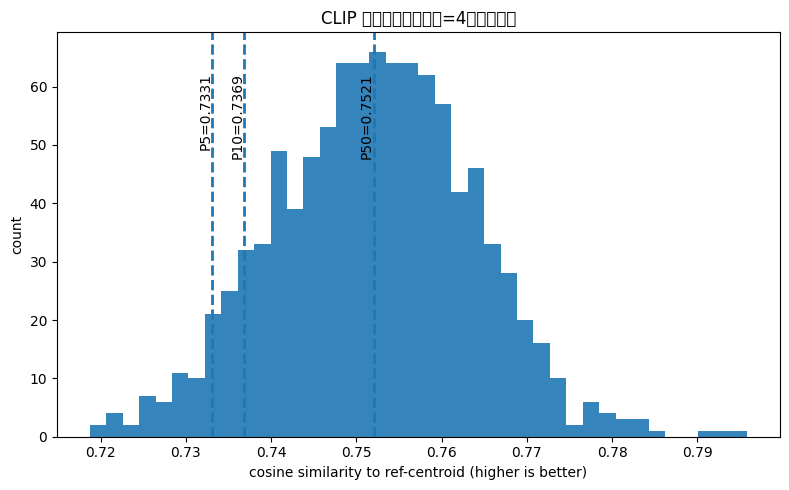

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

[Plot] Saved histogram: samples/outputs_sd21_base_replaced_qps1000_unet0.001_text0.001/clip_similarity_hist.png


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

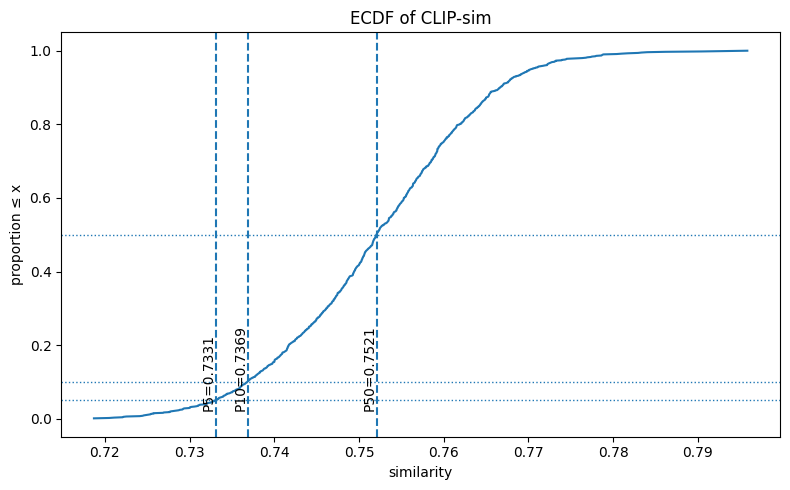

[Plot] Saved ECDF: samples/outputs_sd21_base_replaced_qps1000_unet0.001_text0.001/clip_similarity_ecdf.png
样本组数: 1000, 有效统计组: 1000
分位点（相似度）: {'P5': 0.7330848455429078, 'P10': 0.7368539154529572, 'P50': 0.7520772814750671}
均值: 0.752121 | 中位数: 0.752077 | 最小: 0.718720 | 最大: 0.795841


In [5]:
# === 计算 1000 组生成样本相对参考图的 CLIP 相似度，并可视化下分位点 ===
import os, math, csv, glob
from pathlib import Path

import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']        # 解决中文乱码
plt.rcParams['axes.unicode_minus']=False          # 解决负号显示

# --------- 路径与设置（按需修改）---------
GENERATED_ROOT = OUT_DIR
REF_DIR = "/data/home/yekai/github/DiffAdvPerturbationBench/Algorithms/Anti-DreamBooth/exp_datas_output/aspl_VGGFace2_SD21_random50_r8_savemodels_aglr5e-5/exp_data_ASPL-id0-r8-steps50-1756528573/image_clean_ref"

OUT_CSV  = Path(GENERATED_ROOT) / "clip_similarity_per_group.csv"
SAVE_HIST = Path(GENERATED_ROOT) / "clip_similarity_hist.png"
SAVE_ECDF = Path(GENERATED_ROOT) / "clip_similarity_ecdf.png"

# 选择 CLIP 模型（open_clip 优先；否则回退到 clip）
CLIP_BACKEND = None
OPENCLIP_MODEL = "ViT-B-32"
OPENCLIP_CHECKPOINT = "laion2b_s34b_b79k"
CLIP_MODEL_FALLBACK = "ViT-B/32"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH = 32
TORCH_DTYPE = torch.float32

# --------- 加载 CLIP（open_clip 优先）---------
def load_clip(device=DEVICE):
    global CLIP_BACKEND
    try:
        import open_clip
        model, _, preprocess = open_clip.create_model_and_transforms(
            OPENCLIP_MODEL, pretrained=OPENCLIP_CHECKPOINT, device=device
        )
        model.eval().to(device=device)
        CLIP_BACKEND = "open_clip"
        return model, preprocess
    except Exception as e1:
        try:
            import clip  # OpenAI CLIP
            model, preprocess = clip.load(CLIP_MODEL_FALLBACK, device=device, jit=False)
            model.eval().to(device=device)
            CLIP_BACKEND = "clip"
            return model, preprocess
        except Exception as e2:
            raise RuntimeError(
                f"无法加载 CLIP。请安装 open-clip 或 clip。\nopen_clip 错误: {e1}\nclip 错误: {e2}"
            )

@torch.no_grad()
def encode_images(model, preprocess, img_paths, device=DEVICE, batch=BATCH):
    """返回 (N, D) 的 L2 归一化图像向量"""
    xs = []
    n = len(img_paths)
    for i in range(0, n, batch):
        chunk = img_paths[i:i+batch]
        imgs = [preprocess(Image.open(p).convert("RGB")) for p in chunk]
        t = torch.stack(imgs, dim=0).to(device=device, dtype=TORCH_DTYPE)
        feats = model.encode_image(t)
        feats = feats.float()
        feats = feats / (feats.norm(dim=-1, keepdim=True) + 1e-12)
        xs.append(feats.cpu())
    return torch.cat(xs, dim=0) if xs else torch.empty(0)

def list_sample_groups(root):
    return sorted([p for p in Path(root).glob("sample_*") if p.is_dir()])

def list_images_in_dir(d):
    paths = []
    for ext in ("*.png", "*.jpg", "*.jpeg", "*.webp"):
        paths += glob.glob(str(Path(d) / ext))
    return sorted(paths)

# --------- 1) 准备 CLIP 与参考嵌入 ----------
model, preprocess = load_clip(DEVICE)
ref_imgs = list_images_in_dir(REF_DIR)
assert len(ref_imgs) >= 1, f"参考目录 {REF_DIR} 中未找到图片！"

with torch.no_grad():
    ref_embs = encode_images(model, preprocess, ref_imgs, device=DEVICE, batch=BATCH)  # (R, D)
    ref_centroid = ref_embs.mean(dim=0, keepdim=True)
    ref_centroid = ref_centroid / (ref_centroid.norm(dim=-1, keepdim=True) + 1e-12)   # (1, D)
print(f"[Ref] {len(ref_imgs)} images encoded. Embedding dim={ref_centroid.shape[-1]}")

# --------- 2) 遍历 1000 组样本，计算与参考质心的“相似度” ----------
groups = list_sample_groups(GENERATED_ROOT)
assert len(groups) > 0, f"未找到样本目录 sample_xxxx 于 {GENERATED_ROOT}"
print(f"[Gen] Found {len(groups)} sample groups (expect 1000).")

results = []
all_group_sims = []

for gdir in groups:
    gimgs = list_images_in_dir(gdir)
    if len(gimgs) == 0:
        results.append({
            "group": gdir.name, "n_imgs": 0,
            "mean_sim": math.nan, "median_sim": math.nan,
            "min_sim": math.nan, "max_sim": math.nan
        })
        continue

    with torch.no_grad():
        gen_embs = encode_images(model, preprocess, gimgs, device=DEVICE, batch=BATCH)  # (K, D)
        # 余弦相似度（与参考质心），越大越相似，范围[-1,1]，一般在[0,1]
        sims = torch.matmul(gen_embs, ref_centroid.T).squeeze(-1).cpu().numpy()  # (K,)

    mean_s = float(np.mean(sims))
    med_s  = float(np.median(sims))
    min_s  = float(np.min(sims))
    max_s  = float(np.max(sims))

    results.append({
        "group": gdir.name, "n_imgs": len(gimgs),
        "mean_sim": mean_s, "median_sim": med_s,
        "min_sim": min_s, "max_sim": max_s
    })
    all_group_sims.append(mean_s)

# --------- 3) 保存 CSV ----------
OUT_CSV.parent.mkdir(parents=True, exist_ok=True)
with open(OUT_CSV, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["group","n_imgs","mean_sim","median_sim","min_sim","max_sim"])
    writer.writeheader()
    writer.writerows(results)
print(f"[CSV] Saved: {OUT_CSV}")

# --------- 4) 可视化分布（直方图 + 下分位线：P10、P5、以及中位 P50）---------
vals = np.array([v for v in all_group_sims if not np.isnan(v)])
assert vals.size > 0, "没有有效的组分数用于可视化。"

q_list = [0.05, 0.10, 0.50]             # 下分位：P5、P10；中位：P50
qs = np.quantile(vals, q_list)

plt.figure(figsize=(8,5))
plt.hist(vals, bins=40, alpha=0.9)
for qv, qname in zip(qs, ["P5","P10","P50"]):
    plt.axvline(qv, linestyle="--", linewidth=2)
    plt.text(qv, plt.ylim()[1]*0.9, f"{qname}={qv:.4f}", rotation=90, va="top", ha="right")
plt.title("CLIP 相似度分布（每组=4张的均值）")
plt.xlabel("cosine similarity to ref-centroid (higher is better)")
plt.ylabel("count")
plt.tight_layout()
plt.savefig(SAVE_HIST, dpi=150)
plt.show()
print(f"[Plot] Saved histogram: {SAVE_HIST}")

# --------- 5) ECDF（下分位更直观：0.05、0.10、0.50）---------
sorted_vals = np.sort(vals)
ecdf = np.arange(1, len(sorted_vals)+1) / len(sorted_vals)

plt.figure(figsize=(8,5))
plt.plot(sorted_vals, ecdf)
for qv, qname, qh in zip(qs, ["P5","P10","P50"], [0.05, 0.10, 0.50]):
    plt.axvline(qv, linestyle="--", linewidth=1.5)
    plt.axhline(qh, linestyle=":", linewidth=1.0)
    plt.text(qv, 0.02, f"{qname}={qv:.4f}", rotation=90, va="bottom", ha="right")
plt.title("ECDF of CLIP-sim")
plt.xlabel("similarity")
plt.ylabel("proportion ≤ x")
plt.tight_layout()
plt.savefig(SAVE_ECDF, dpi=150)
plt.show()
print(f"[Plot] Saved ECDF: {SAVE_ECDF}")

# --------- 6) 小结输出 ----------
print(f"样本组数: {len(groups)}, 有效统计组: {vals.size}")
print("分位点（相似度）:", {"P5": float(qs[0]), "P10": float(qs[1]), "P50": float(qs[2])})
print(f"均值: {vals.mean():.6f} | 中位数: {np.median(vals):.6f} | 最小: {vals.min():.6f} | 最大: {vals.max():.6f}")

[Ref] 4 images encoded. Embedding dim=512
[Gen] Found 6 sample groups (expect 1000).


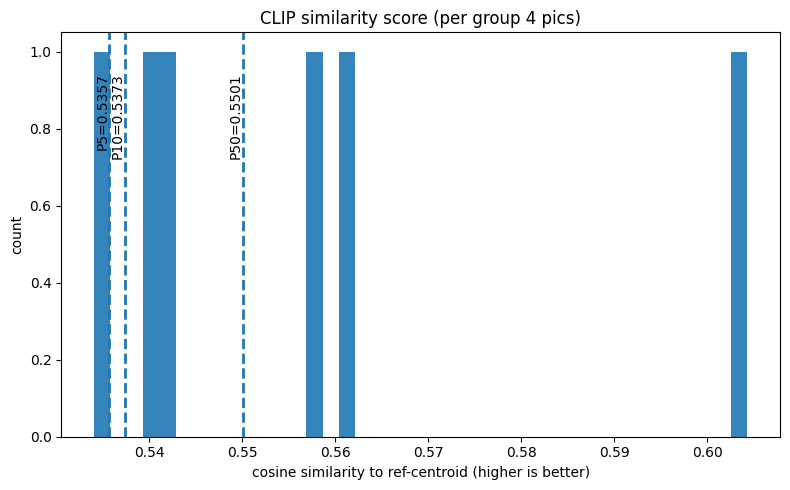

[Plot] Saved histogram: /data/home/yekai/github/DiffAdvPerturbationBench/PUEs/samples/outputs_sd21_base_replaced_qps1000_trainrobust_unet0.0001_text0.0001/clip_similarity_hist.png


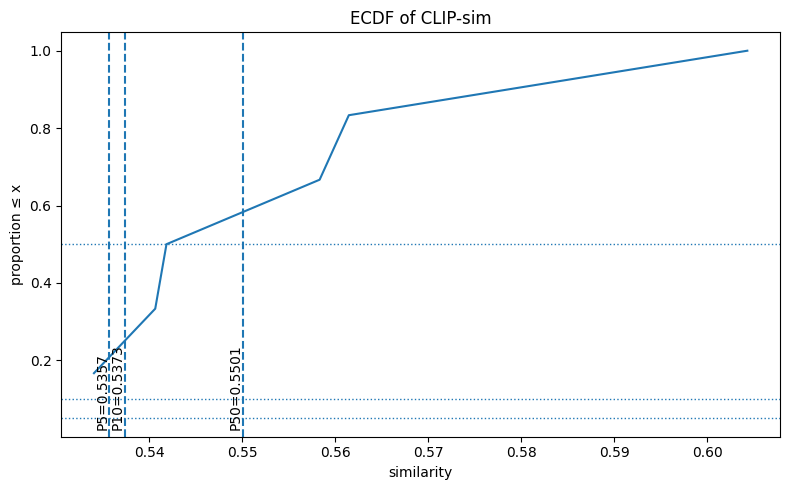

In [2]:
show_sim_dis("/data/home/yekai/github/DiffAdvPerturbationBench/PUEs/samples/outputs_sd21_base_replaced_qps1000_trainrobust_unet0.0001_text0.0001","/data/home/yekai/github/DiffAdvPerturbationBench/Algorithms/Anti-DreamBooth/exp_datas_output/aspl_VGGFace2_SD21_random50_r8_savemodels_aglr5e-5/exp_data_ASPL-id0-r8-steps50-1756528573/image_clean_ref")

In [ ]:
# === 计算 1000 组生成样本相对参考图的 CLIP 相似度，并可视化下分位点 ===
import os, math, csv, glob
from pathlib import Path

import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
# import warnings
# plt.rcParams['font.sans-serif']=['SimHei']        # 解决中文乱码
# plt.rcParams['axes.unicode_minus']=False          # 解决负号显示

def show_sim_dis(GENERATED_ROOT,REF_DIR,save_path):
    # warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
    # plt.rcParams['font.sans-serif']=['SimHei']        # 解决中文乱码
    # plt.rcParams['axes.unicode_minus']=False     
    # --------- 路径与设置（按需修改）---------
    # GENERATED_ROOT = OUT_DIR
    # REF_DIR = "/data/home/yekai/github/DiffAdvPerturbationBench/Algorithms/Anti-DreamBooth/exp_datas_output/aspl_VGGFace2_SD21_random50_r8_savemodels_aglr5e-5/exp_data_ASPL-id0-r8-steps50-1756528573/image_clean_ref"

    OUT_CSV  = Path(GENERATED_ROOT) / "clip_similarity_per_group.csv"
    SAVE_HIST = Path(save_path) / "clip_similarity_hist.png"
    SAVE_ECDF = Path(save_path) / "clip_similarity_ecdf.png"

    # 选择 CLIP 模型（open_clip 优先；否则回退到 clip）
    CLIP_BACKEND = None
    OPENCLIP_MODEL = "ViT-B-32"
    OPENCLIP_CHECKPOINT = "laion2b_s34b_b79k"
    CLIP_MODEL_FALLBACK = "ViT-B/32"

    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    BATCH = 32
    TORCH_DTYPE = torch.float32

    # --------- 加载 CLIP（open_clip 优先）---------
    def load_clip(device=DEVICE):
        global CLIP_BACKEND
        try:
            import open_clip
            model, _, preprocess = open_clip.create_model_and_transforms(
                OPENCLIP_MODEL, pretrained=OPENCLIP_CHECKPOINT, device=device
            )
            model.eval().to(device=device)
            CLIP_BACKEND = "open_clip"
            return model, preprocess
        except Exception as e1:
            try:
                import clip  # OpenAI CLIP
                model, preprocess = clip.load(CLIP_MODEL_FALLBACK, device=device, jit=False)
                model.eval().to(device=device)
                CLIP_BACKEND = "clip"
                return model, preprocess
            except Exception as e2:
                raise RuntimeError(
                    f"无法加载 CLIP。请安装 open-clip 或 clip。\nopen_clip 错误: {e1}\nclip 错误: {e2}"
                )

    @torch.no_grad()
    def encode_images(model, preprocess, img_paths, device=DEVICE, batch=BATCH):
        """返回 (N, D) 的 L2 归一化图像向量"""
        xs = []
        n = len(img_paths)
        for i in range(0, n, batch):
            chunk = img_paths[i:i+batch]
            imgs = [preprocess(Image.open(p).convert("RGB")) for p in chunk]
            t = torch.stack(imgs, dim=0).to(device=device, dtype=TORCH_DTYPE)
            feats = model.encode_image(t)
            feats = feats.float()
            feats = feats / (feats.norm(dim=-1, keepdim=True) + 1e-12)
            xs.append(feats.cpu())
        return torch.cat(xs, dim=0) if xs else torch.empty(0)

    def list_sample_groups(root):
        return sorted([p for p in Path(root).glob("sample_*") if p.is_dir()])

    def list_images_in_dir(d):
        paths = []
        for ext in ("*.png", "*.jpg", "*.jpeg", "*.webp"):
            paths += glob.glob(str(Path(d) / ext))
        return sorted(paths)

    # --------- 1) 准备 CLIP 与参考嵌入 ----------
    model, preprocess = load_clip(DEVICE)
    ref_imgs = list_images_in_dir(REF_DIR)
    assert len(ref_imgs) >= 1, f"参考目录 {REF_DIR} 中未找到图片！"

    with torch.no_grad():
        ref_embs = encode_images(model, preprocess, ref_imgs, device=DEVICE, batch=BATCH)  # (R, D)
        ref_centroid = ref_embs.mean(dim=0, keepdim=True)
        ref_centroid = ref_centroid / (ref_centroid.norm(dim=-1, keepdim=True) + 1e-12)   # (1, D)
    print(f"[Ref] {len(ref_imgs)} images encoded. Embedding dim={ref_centroid.shape[-1]}")

    # --------- 2) 遍历 1000 组样本，计算与参考质心的“相似度” ----------
    groups = list_sample_groups(GENERATED_ROOT)
    assert len(groups) > 0, f"未找到样本目录 sample_xxxx 于 {GENERATED_ROOT}"
    print(f"[Gen] Found {len(groups)} sample groups (expect 1000).")

    results = []
    all_group_sims = []

    for gdir in groups:
        gimgs = list_images_in_dir(gdir)
        if len(gimgs) == 0:
            results.append({
                "group": gdir.name, "n_imgs": 0,
                "mean_sim": math.nan, "median_sim": math.nan,
                "min_sim": math.nan, "max_sim": math.nan
            })
            continue

        with torch.no_grad():
            gen_embs = encode_images(model, preprocess, gimgs, device=DEVICE, batch=BATCH)  # (K, D)
            # 余弦相似度（与参考质心），越大越相似，范围[-1,1]，一般在[0,1]
            sims = torch.matmul(gen_embs, ref_centroid.T).squeeze(-1).cpu().numpy()  # (K,)

        mean_s = float(np.mean(sims))
        med_s  = float(np.median(sims))
        min_s  = float(np.min(sims))
        max_s  = float(np.max(sims))

        results.append({
            "group": gdir.name, "n_imgs": len(gimgs),
            "mean_sim": mean_s, "median_sim": med_s,
            "min_sim": min_s, "max_sim": max_s
        })
        all_group_sims.append(mean_s)

    # --------- 3) 保存 CSV ----------
    # OUT_CSV.parent.mkdir(parents=True, exist_ok=True)
    # with open(OUT_CSV, "w", newline="") as f:
    #     writer = csv.DictWriter(f, fieldnames=["group","n_imgs","mean_sim","median_sim","min_sim","max_sim"])
    #     writer.writeheader()
    #     writer.writerows(results)
    # print(f"[CSV] Saved: {OUT_CSV}")

    # --------- 4) 可视化分布（直方图 + 下分位线：P10、P5、以及中位 P50）---------
    vals = np.array([v for v in all_group_sims if not np.isnan(v)])
    assert vals.size > 0, "没有有效的组分数用于可视化。"

    q_list = [0.05, 0.10, 0.50]             # 下分位：P5、P10；中位：P50
    qs = np.quantile(vals, q_list)

    plt.figure(figsize=(8,5))
    plt.hist(vals, bins=40, alpha=0.9)
    for qv, qname in zip(qs, ["P5","P10","P50"]):
        plt.axvline(qv, linestyle="--", linewidth=2)
        plt.text(qv, plt.ylim()[1]*0.9, f"{qname}={qv:.4f}", rotation=90, va="top", ha="right")
    plt.title("CLIP similarity score (per group 4 pics)")
    plt.xlabel("cosine similarity to ref-centroid (higher is better)")
    plt.ylabel("count")
    plt.tight_layout()
    plt.savefig(SAVE_HIST, dpi=150)
    plt.show()
    print(f"[Plot] Saved histogram: {SAVE_HIST}")

    # --------- 5) ECDF（下分位更直观：0.05、0.10、0.50）---------
    sorted_vals = np.sort(vals)
    ecdf = np.arange(1, len(sorted_vals)+1) / len(sorted_vals)

    plt.figure(figsize=(8,5))
    plt.plot(sorted_vals, ecdf)
    for qv, qname, qh in zip(qs, ["P5","P10","P50"], [0.05, 0.10, 0.50]):
        plt.axvline(qv, linestyle="--", linewidth=1.5)
        plt.axhline(qh, linestyle=":", linewidth=1.0)
        plt.text(qv, 0.02, f"{qname}={qv:.4f}", rotation=90, va="bottom", ha="right")
    plt.title("ECDF of CLIP-sim")
    plt.xlabel("similarity")
    plt.ylabel("proportion ≤ x")
    plt.tight_layout()
    plt.savefig(SAVE_ECDF, dpi=150)
    plt.show()
    # print(f"[Plot] Saved ECDF: {SAVE_ECDF}")

    # # --------- 6) 小结输出 ----------
    # print(f"样本组数: {len(groups)}, 有效统计组: {vals.size}")
    # print("分位点（相似度）:", {"P5": float(qs[0]), "P10": float(qs[1]), "P50": float(qs[2])})
    # print(f"均值: {vals.mean():.6f} | 中位数: {np.median(vals):.6f} | 最小: {vals.min():.6f} | 最大: {vals.max():.6f}")

In [ ]:
# # --------- 保存 CSV ----------
# from pathlib import Path
# import csv

# OUT_CSV = Path(GENERATED_ROOT) / "clip_distance_per_group.csv"
# OUT_CSV.parent.mkdir(parents=True, exist_ok=True)

# with open(OUT_CSV, "w", newline="") as f:
#     writer = csv.DictWriter(
#         f,
#         fieldnames=["group", "n_imgs", "mean_dist", "median_dist", "min_dist", "max_dist"]
#     )
#     writer.writeheader()
#     writer.writerows(results)

# print(f"[CSV] Saved: {OUT_CSV}")
# --------- 保存 CSV ----------
from pathlib import Path
import csv

OUT_CSV = Path(GENERATED_ROOT) / "clip_distance_per_group.csv"
OUT_CSV.parent.mkdir(parents=True, exist_ok=True)

with open(OUT_CSV, "w", newline="") as f:
    writer = csv.DictWriter(
        f,
        fieldnames=["group", "n_imgs", "mean_sim", "median_sim", "min_sim", "max_sim"]
    )
    writer.writeheader()
    writer.writerows(results)

print(f"[CSV] Saved: {OUT_CSV}")

#### $\eta$ 扩展

N (有效样本组数) = 1000


,eta,q_upper,k_u,CLS
0,0.0000,0.900000,928,0.768323
1,0.0001,0.916445,942,0.769815
2,0.0002,0.930770,954,0.771106
3,0.0003,0.943124,964,0.772363
4,0.0004,0.953672,973,0.773923
5,0.0005,0.962589,980,0.776784
6,0.0006,0.970052,985,0.777994
7,0.0007,0.976235,990,0.780434
8,0.0008,0.981308,993,0.782948
9,0.0009,0.985429,996,0.786152


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

Saved: outputs_sd21_base_replaced_qps1000_unet1e-3_text5e-4/eta_extension_results.csv


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

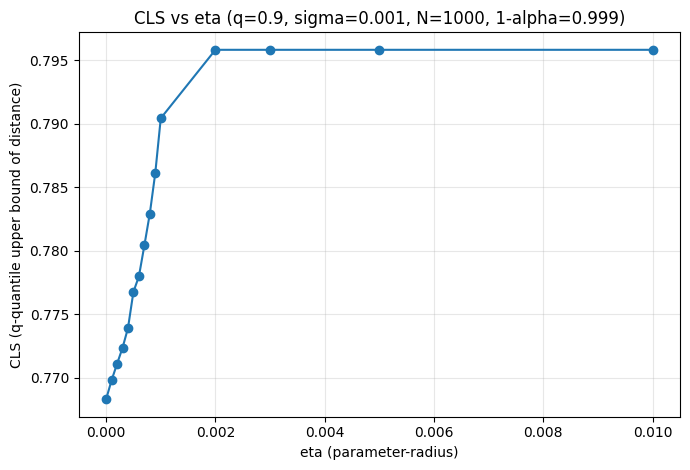

In [13]:
# === η 扩展：在已有 1000 个分数上计算 (q, η)-Learnability 的认证上界（CLS） ===
import math
import csv
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# 1) 读入 1000 组的分数（上一段代码导出的 CSV）
# GENERATED_ROOT = "./outputs_sd21_base_replaced_qps1000_unet1e-3_text5e-4"
CSV_PATH = Path(GENERATED_ROOT) / "clip_distance_per_group.csv"
assert CSV_PATH.exists(), f"找不到 {CSV_PATH}"

vals = []
with open(CSV_PATH, "r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        if row["mean_sim"] == "" or row["mean_sim"] is None:
            continue
        x = float(row["mean_sim"])
        if not math.isnan(x):
            vals.append(x)

vals = np.array(vals, dtype=float)
vals.sort()                         # 升序：小的“距离”更相似
N = len(vals)
assert N > 0, "没有有效分数可用于 η 扩展"
print(f"N (有效样本组数) = {N}")

# 2) 设定认证超参
Q = 0.90            # q 分位（你也可以改成 0.95 等）
ALPHA = 0.001       # 置信度 1-ALPHA（越小越保守）
# 你的固定权重噪声（来自采样阶段）
SIGMA_UNET = 1e-3
SIGMA_TEXT = 1e-3
# 保守做法：取最小 σ
SIGMA = min(SIGMA_UNET, SIGMA_TEXT)

# η 网格（可按需扩展/修改；单位与“参数范数半径”一致）
ETAS = [0.0, 0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.002,0.003,0.005,0.01 ]

# 3) 标准正态 CDF / PPF（不依赖 scipy）
def norm_cdf(x):
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def norm_ppf(q: float) -> float:
    """
    标准正态分布的反CDF：Phi^{-1}(q)
    用 PyTorch 的 erfinv 实现，避免依赖 numpy/scipy.special。
    """
    import math, torch
    q = float(q)
    q = min(max(q, 1e-12), 1.0 - 1e-12)  # 防极端
    t = torch.tensor(2.0 * q - 1.0, dtype=torch.float64)
    try:
        inv = torch.special.erfinv(t)     # 新版 torch
    except AttributeError:
        inv = torch.erfinv(t)             # 旧版 torch
    return float(math.sqrt(2.0) * inv.item())

def q_upper_of_eta(q, eta, sigma):
    return norm_cdf(norm_ppf(q) + (eta / max(sigma, 1e-12)))

# 4) 计算 k_u（Clopper–Pearson 的二项分布分位；无 scipy 则正态近似）
def ku_from_binom_ppf(n, p, alpha):
    """
    返回最小整数 k，使得 BinomCDF(k; n, p) >= 1 - alpha。
    首选 scipy 精确值；否则用正态近似：k ≈ floor(n p + z * sqrt(n p (1-p))).
    """
    try:
        from scipy.stats import binom
        k = int(binom.ppf(1.0 - alpha, n, p))
        return min(max(k, 0), n-1)
    except Exception:
        # 正态近似（连续性修正 +0.5 可选）
        z = norm_ppf(1.0 - alpha)
        mu = n * p
        var = n * p * (1.0 - p)
        sd = math.sqrt(max(var, 1e-12))
        k = int(math.floor(mu + z * sd))
        return min(max(k, 0), n-1)

# 5) 逐 η 计算 q_upper、k_u、CLS（取第 k_u 个顺序统计量）
rows = []
for eta in ETAS:
    q_up = q_upper_of_eta(Q, eta, SIGMA)
    q_up = min(max(q_up, 0.0), 1.0)
    k_u  = ku_from_binom_ppf(N, q_up, ALPHA)
    # 若 k_u 已经达到末尾，说明 q_upper 过大（极保守），可视为接近“Abstain”边缘
    cls = float(vals[k_u])  # 该 η 下的认证上界阈值
    rows.append((eta, q_up, k_u, cls))

# 6) 打印/保存表格，并作图
import pandas as pd
df = pd.DataFrame(rows, columns=["eta", "q_upper", "k_u", "CLS"])
display(df)

csv_out = Path(GENERATED_ROOT) / "eta_extension_results.csv"
df.to_csv(csv_out, index=False)
print(f"Saved: {csv_out}")

# 7) 可视化 CLS vs eta
plt.figure(figsize=(7,4.8))
plt.plot(df["eta"], df["CLS"], marker="o")
plt.xlabel("eta (parameter-radius)")
plt.ylabel("CLS (q-quantile upper bound of distance)")
plt.title(f"CLS vs eta (q={Q}, sigma={SIGMA:g}, N={N}, 1-alpha={1-ALPHA})")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
# === η 扩展（不依赖 numpy.special / scipy）===
import math, csv
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

# 1) 读入 1000 组分数
GENERATED_ROOT = "./outputs_sd21_base_replaced_qps1000_unet1e-3_text5e-4"
CSV_PATH = Path(GENERATED_ROOT) / "clip_distance_per_group.csv"
assert CSV_PATH.exists(), f"找不到 {CSV_PATH}"

vals = []
with open(CSV_PATH, "r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        x = row.get("mean_dist", "")
        if x == "" or x is None:
            continue
        x = float(x)
        if not math.isnan(x):
            vals.append(x)

vals = np.array(vals, dtype=float)
vals.sort()
N = len(vals)
assert N > 0, "没有有效分数可用于 η 扩展"
print(f"N (有效样本组数) = {N}")

# 2) 认证超参
Q = 0.90       # 分位点 q
ALPHA = 0.001  # 置信度 1-ALPHA
# 你的采样噪声（固定值），η 扩展用一个保守 σ；这里取 min
SIGMA_UNET = 1e-3
SIGMA_TEXT = 5e-4
SIGMA = min(SIGMA_UNET, SIGMA_TEXT)

# ETAS = [0.0, 0.001, 0.005, 0.01, 0.05,
#         0.10, 0.15, 0.20, 0.25, 0.30,
#         0.40, 0.50, 0.60, 0.70, 0.80]
ETAS = [
  0.0,
  1.0e-4, 2.0e-4, 3.0e-4, 4.0e-4, 5.0e-4,
  6.0e-4, 7.0e-4, 8.0e-4, 9.0e-4, 1.0e-3,
  1.25e-3, 1.50e-3, 1.75e-3, 2.0e-3
]
# 3) 标准正态 CDF/PPF（Acklam 近似）
def norm_cdf(x: float) -> float:
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def norm_ppf(q: float) -> float:
    """Acklam approximation of Phi^{-1}(q). q in (0,1)."""
    if not (0.0 < q < 1.0):
        raise ValueError("q must be in (0,1)")
    # Coefficients for rational approximations
    a = [-3.969683028665376e+01,  2.209460984245205e+02, -2.759285104469687e+02,
          1.383577518672690e+02, -3.066479806614716e+01,  2.506628277459239e+00]
    b = [-5.447609879822406e+01,  1.615858368580409e+02, -1.556989798598866e+02,
          6.680131188771972e+01, -1.328068155288572e+01]
    c = [-7.784894002430293e-03, -3.223964580411365e-01, -2.400758277161838e+00,
         -2.549732539343734e+00,  4.374664141464968e+00,  2.938163982698783e+00]
    d = [ 7.784695709041462e-03,  3.224671290700398e-01,
          2.445134137142996e+00,  3.754408661907416e+00]
    plow  = 0.02425
    phigh = 1 - plow
    if q < plow:
        r = math.sqrt(-2.0*math.log(q))
        return (((((c[0]*r + c[1])*r + c[2])*r + c[3])*r + c[4])*r + c[5]) / \
               ((((d[0]*r + d[1])*r + d[2])*r + d[3])*r + 1.0)
    if q > phigh:
        r = math.sqrt(-2.0*math.log(1.0 - q))
        return -(((((c[0]*r + c[1])*r + c[2])*r + c[3])*r + c[4])*r + c[5]) / \
                 ((((d[0]*r + d[1])*r + d[2])*r + d[3])*r + 1.0)
    # central region
    r = q - 0.5
    s = r*r
    return (((((a[0]*s + a[1])*s + a[2])*s + a[3])*s + a[4])*s + a[5]) * r / \
           (((((b[0]*s + b[1])*s + b[2])*s + b[3])*s + b[4])*s + 1.0)

def q_upper_of_eta(q: float, eta: float, sigma: float) -> float:
    z = norm_ppf(min(max(q, 1e-12), 1 - 1e-12))
    return min(max(norm_cdf(z + eta / max(sigma, 1e-12)), 0.0), 1.0)

# 4) 计算 k_u（有 scipy 就用精确 ppf；否则正态近似）
def ku_from_binom_ppf(n: int, p: float, alpha: float) -> int:
    try:
        from scipy.stats import binom
        k = int(binom.ppf(1.0 - alpha, n, p))
    except Exception:
        z = norm_ppf(1.0 - alpha)
        mu = n * p
        var = n * p * (1.0 - p)
        sd = math.sqrt(max(var, 1e-12))
        k = int(math.floor(mu + z * sd))   # 连续性修正可 +0.5，这里略去
    return min(max(k, 0), n-1)

# 5) η 扩展主循环
rows = []
for eta in ETAS:
    q_up = q_upper_of_eta(Q, eta, SIGMA)
    k_u  = ku_from_binom_ppf(N, q_up, ALPHA)
    cls  = float(vals[k_u])  # 该 η 下的认证上界（距离阈值）
    rows.append((eta, q_up, k_u, cls))

df = pd.DataFrame(rows, columns=["eta", "q_upper", "k_u", "CLS"])
display(df)

out_csv = Path(GENERATED_ROOT) / "eta_extension_results.csv"
df.to_csv(out_csv, index=False)
print("Saved:", out_csv)

# 6) 可视化 CLS vs eta
plt.figure(figsize=(7,4.6))
plt.plot(df["eta"], df["CLS"], marker="o")
plt.xlabel("eta (parameter-radius)")
plt.ylabel("CLS (distance upper bound at q)")
plt.title(f"CLS vs eta (q={Q}, sigma={SIGMA:g}, N={N}, 1-alpha={1-ALPHA})")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

AssertionError: 没有有效分数可用于 η 扩展